# Setup

In [50]:
%%capture
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q bert_score

In [51]:
import os
import copy
import random
import torch
import evaluate

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    device = 'cuda'
print(device)

cuda


In [53]:
def set_css():
    """
    Function to wrap cell outputs
    """
    from IPython.display import HTML, display

    display(HTML('''
    <style>
        pre {
            white-space: pre-wrap;
        }
    </style>
    '''))

    return

get_ipython().events.register('pre_run_cell', set_css)

In [54]:
%%capture
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')
bert = evaluate.load('bertscore')

In [55]:
# change to project directory
project_folder = 'drive/MyDrive/Datasci266/w266_project'

if not project_folder in os.getcwd():
    os.chdir(project_folder)

In [56]:
# previous mapping
# {"{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, \
# 'max_length': 125, 'min_length': 22, 'temperature': 1}": 'base',
# "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, \
# 'max_length': 125, 'min_length': 22, 'temperature': 1.1}": 1,
# "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, \
# 'max_length': 50, 'min_length': 22, 'temperature': 1}": 2,
# "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, \
# 'max_length': 50, 'min_length': 22, 'temperature': 1.1}": 3}

In [57]:
# --- load data --- #
df = pd.read_pickle('data/isolated_summaries.pkl')
df = df.reset_index(drop=True)

# --- relabel unique metadata combinations --- #

metadata_mapping = {
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1}": 'A',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1}": 'B',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1.1}": 'C',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1.1}": 'D',
}

# --- apply metadata_mapping to metadata column --- #
df['metadata'] = df['metadata'].apply(
    lambda x: metadata_mapping[x]
)

df.tail(2)

,title,abstract,base_bart_model,finetuned_model,mlm_ft_3e_model,mlm_ft_6e_model,id,run,metadata
398,The rate of transient beta frequency events pr...,Beta frequency oscillations (15-29Hz) are amon...,Beta frequency oscillations (15-29Hz) are amon...,Functional differences in averaged prestimulus...,Predicting transient brain rhythms in human se...,Functional differences in averaged prestimulus...,14,25,D
399,Membrane state diagrams make electrophysiologi...,Ion channels are ubiquitous in living systems....,membrane bioelectricity bears on fields rangi...,Making conductance models of membrane potentia...,The membrane differential equation central to ...,Modeling the membrane differential equation ce...,15,25,D


In [58]:
df.head(2)

,title,abstract,base_bart_model,finetuned_model,mlm_ft_3e_model,mlm_ft_6e_model,id,run,metadata
0,Biophysical modeling of frontocentral ERP gene...,Human frontocentral event-related potentials (...,Frontocentral event-related potentials (FC-ERP...,Cellular and circuit mechanisms of the frontoc...,Human frontocentral event-related potentials a...,A biophysical model of frontocentral event-rel...,0,1,A
1,Distinct neocortical mechanisms underlie human...,Magneto- and/or electro-encephalography (M/EEG...,Magneto- and/or electro-encephalography (M/EEG...,Neurophysiological Mechanisms of Distinct Macr...,The neural dynamics of somatosensory cortex ev...,Reconstruction of cortical laminar circuit mec...,1,1,A


# Loss and Accuracy

In [59]:
all_epoch_results = pd.read_pickle(
    'states/mlm_state_checkpoints/all_epoch_results.pkl'
)
all_epoch_results = all_epoch_results.reset_index()
all_epoch_results.rename(columns={'index': 'epoch'}, inplace=True)

all_epoch_results


,epoch,train_acc_history,train_loss_history,val_acc,val_loss,avg_train_acc,avg_train_loss
0,1,"[0.04594, 0.03141, 0.06468, 0.05348, 0.06637, ...","[7.481509208679199, 7.543937683105469, 6.97856...",0.55318,2.36940,0.361740,3.888761
1,2,"[0.4065, 0.43871, 0.48128, 0.4712, 0.49062, 0....","[3.4254109859466553, 2.984271287918091, 2.8574...",0.60824,2.04127,0.524287,2.573700
2,3,"[0.50676, 0.56078, 0.58673, 0.6, 0.59596, 0.69...","[2.6253819465637207, 2.32303786277771, 2.43906...",0.6369,1.84470,0.575774,2.187110
3,4,"[0.62189, 0.64286, 0.58824, 0.58779, 0.51977, ...","[1.7535549402236938, 1.8005677461624146, 1.989...",0.65946,1.69546,0.611578,1.935669
4,5,"[0.63433, 0.575, 0.61597, 0.64093, 0.5942, 0.6...","[1.77918541431427, 1.8095648288726807, 1.86885...",0.67633,1.58245,0.639451,1.743550
5,6,"[0.6257, 0.56707, 0.59686, 0.61765, 0.63226, 0...","[1.5415173768997192, 2.3255720138549805, 2.172...",0.67775,1.58272,0.624509,1.863832
6,7,"[0.57576, 0.66026, 0.67421, 0.69886, 0.63725, ...","[2.03509259223938, 1.9619940519332886, 1.46818...",0.67775,1.58272,0.624793,1.862457


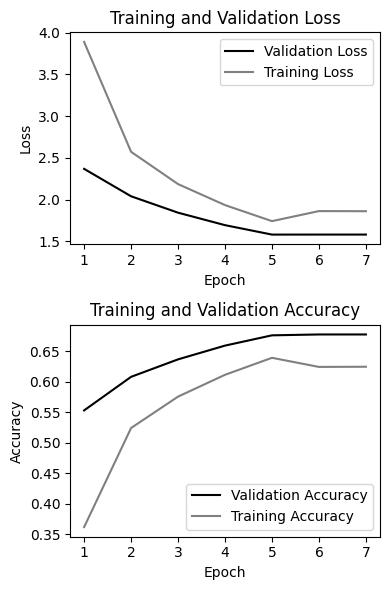

In [60]:
# --- Grid Plot for Loss and Accuracy --- #
fig, axs = plt.subplots(2, 1, figsize=(4, 6))

# plot loss
sns.lineplot(data=all_epoch_results, x='epoch', y='val_loss', label='Validation Loss', color="black", ax=axs[0])
sns.lineplot(data=all_epoch_results, x='epoch', y='avg_train_loss', label='Training Loss', color="grey", ax=axs[0])
axs[0].set_title('Training and Validation Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# plot accuracy
sns.lineplot(data=all_epoch_results, x='epoch', y='val_acc', label='Validation Accuracy', color="black", ax=axs[1])
sns.lineplot(data=all_epoch_results, x='epoch', y='avg_train_acc', label='Training Accuracy', color="grey", ax=axs[1])
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()


plt.tight_layout()
plt.show()

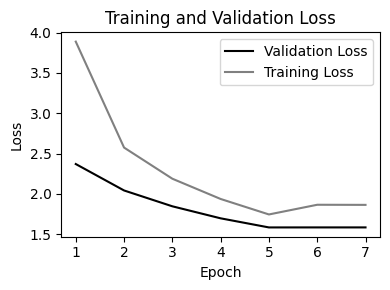

In [61]:
# --- Single Plot for Loss or Accuracy --- #
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

plot_loss=True

if plot_loss:
    plot_acc=False
else:
    plot_acc=True

if plot_loss:
    sns.lineplot(data=all_epoch_results, x='epoch', y='val_loss', label='Validation Loss', color="black", ax=axs)
    sns.lineplot(data=all_epoch_results, x='epoch', y='avg_train_loss', label='Training Loss', color="grey", ax=axs)
    axs.set_title('Training and Validation Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.legend()

if plot_acc:
    sns.lineplot(data=all_epoch_results, x='epoch', y='val_acc', label='Validation Accuracy', color="black", ax=axs)
    sns.lineplot(data=all_epoch_results, x='epoch', y='avg_train_acc', label='Training Accuracy', color="grey", ax=axs)
    axs.set_title('Training and Validation Accuracy')
    axs.set_ylabel('Accuracy')
    axs.set_xlabel('Epoch')
    axs.legend()


plt.tight_layout()
plt.show()

# Summary Evaluation Metrics

In [62]:
print(df.columns)
df.tail(2)

Index(['title', 'abstract', 'base_bart_model', 'finetuned_model',
       'mlm_ft_3e_model', 'mlm_ft_6e_model', 'id', 'run', 'metadata'],
      dtype='object')


,title,abstract,base_bart_model,finetuned_model,mlm_ft_3e_model,mlm_ft_6e_model,id,run,metadata
398,The rate of transient beta frequency events pr...,Beta frequency oscillations (15-29Hz) are amon...,Beta frequency oscillations (15-29Hz) are amon...,Functional differences in averaged prestimulus...,Predicting transient brain rhythms in human se...,Functional differences in averaged prestimulus...,14,25,D
399,Membrane state diagrams make electrophysiologi...,Ion channels are ubiquitous in living systems....,membrane bioelectricity bears on fields rangi...,Making conductance models of membrane potentia...,The membrane differential equation central to ...,Modeling the membrane differential equation ce...,15,25,D


In [63]:
models = [
    'base_bart_model',
    'finetuned_model',
    'mlm_ft_3e_model',
    'mlm_ft_6e_model'
]

In [64]:
def get_rouge_scores(
        data,
        models,
        rouge_evaluator=False,
        bleu_evaluator=False,
        bert_score_evaluator=False,
    ):
    """
    Evaluate model summaries against article titles
    """
    df = data.copy()
    remove_cols = df.columns[~df.columns.isin(['run', 'id', 'metadata'])]

    def rouge_scores(row):
        summary = row[model]
        title = row['title']

        return rouge_evaluator.compute(
            predictions=[summary],
            references=[title],
        )

    def bleu_scores(row):
        summary = row[model]
        title = row['title']

        return bleu_evaluator.compute(
            predictions=[summary],
            references=[title],
        )

    def bert_scores(row):
        summary = row[model]
        title = row['title']

        return bert_score_evaluator.compute(
            predictions=[summary],
            references=[title],
            lang='en',
        )

    for model in models:
        if not rouge_evaluator == False:
            print(f'\nComputing rouge scores for {model}...')
            new_col = f'rouge_{model}'
            df[new_col] =  df.apply(rouge_scores, axis=1)
        if not bleu_evaluator == False:
            print(f'\nComputing bleu scores for {model}...')
            new_col = f'bleu_{model}'
            df[new_col] =  df.apply(bleu_scores, axis=1)
        if not bert_score_evaluator == False:
            print(f'\nComputing bert scores for {model}...')
            new_col = f'bert_{model}'
            df[new_col] =  df.apply(bert_scores, axis=1)

    # drop og_columns
    df = df.drop(remove_cols, axis=1)

    return df.reset_index(drop=True)

In [65]:
save_rerun_metrics = False
rerun_all_metrics = False
rerun_new_rows = False

df_metrics = pd.read_pickle('data/all_metrics.pkl')

if rerun_all_metrics:
    print('Re running metrics')
    df_metrics = get_rouge_scores(
        df,
        models,
        rouge_evaluator=rouge,
        bleu_evaluator=bleu,
        bert_score_evaluator=bert,
    )

    if save_rerun_metrics:
        df_metrics.to_pickle('data/all_metrics.pkl')

if rerun_new_rows:
    highest_run = max(df_metrics['run'])
    new_runs = df[df['run'] > highest_run]

    new_metrics = get_rouge_scores(
        new_runs,
        models,
        rouge_evaluator=rouge,
        bleu_evaluator=bleu,
        bert_score_evaluator=bert,
    )

    if save_rerun_metrics:
        df_metrics = pd.concat(
            [df_metrics, new_metrics],
            ignore_index=True
        )

        # check that metadata was carried forward
        if df_metrics['metadata'].isnull().sum() == 0:
            df_metrics.to_pickle('data/all_metrics.pkl')

In [66]:
df_metrics.tail(2)

,id,run,metadata,rouge_base_bart_model,bleu_base_bart_model,bert_base_bart_model,rouge_finetuned_model,bleu_finetuned_model,bert_finetuned_model,rouge_mlm_ft_3e_model,bleu_mlm_ft_3e_model,bert_mlm_ft_3e_model,rouge_mlm_ft_6e_model,bleu_mlm_ft_6e_model,bert_mlm_ft_6e_model
398,14,25,D,"{'rouge1': 0.1568627450980392, 'rouge2': 0.040...","{'bleu': 0.0, 'precisions': [0.073170731707317...","{'precision': [0.826073169708252], 'recall': [...","{'rouge1': 0.2105263157894737, 'rouge2': 0.0, ...","{'bleu': 0.0, 'precisions': [0.130434782608695...","{'precision': [0.8638347387313843], 'recall': ...","{'rouge1': 0.18181818181818182, 'rouge2': 0.0,...","{'bleu': 0.0, 'precisions': [0.15, 0.0, 0.0, 0...","{'precision': [0.8435379266738892], 'recall': ...","{'rouge1': 0.12903225806451615, 'rouge2': 0.0,...","{'bleu': 0.0, 'precisions': [0.125, 0.0, 0.0, ...","{'precision': [0.8688791394233704], 'recall': ..."
399,15,25,D,"{'rouge1': 0.09090909090909091, 'rouge2': 0.0,...","{'bleu': 0.0, 'precisions': [0.025641025641025...","{'precision': [0.8435938358306885], 'recall': ...","{'rouge1': 0.3846153846153846, 'rouge2': 0.083...","{'bleu': 0.0, 'precisions': [0.2, 0.0526315789...","{'precision': [0.8746941685676575], 'recall': ...","{'rouge1': 0.23076923076923078, 'rouge2': 0.0,...","{'bleu': 0.0, 'precisions': [0.1, 0.0, 0.0, 0....","{'precision': [0.8872856497764587], 'recall': ...","{'rouge1': 0.16, 'rouge2': 0.0, 'rougeL': 0.16...","{'bleu': 0.0, 'precisions': [0.058823529411764...","{'precision': [0.8655124306678772], 'recall': ..."


In [67]:
def expand_metrics(
        data,
    ):

    df = data.copy()
    df = df.dropna()

    all_metrics = {
        'rouge':pd.DataFrame(),
        'bleu':pd.DataFrame(),
        'bert':pd.DataFrame(),
    }

    for col in df.columns:
        if 'rouge' in col:

            tmp = df[[col, 'id', 'run' , 'metadata']].copy()
            tmp['model'] = col.split('rouge_')[1]
            tmp = pd.concat(
                [tmp.drop([col], axis=1),
                 tmp[col].apply(pd.Series)], axis=1)

            all_metrics['rouge'] = pd.concat(
                [all_metrics['rouge'], tmp], ignore_index=True,
            )

        if 'bleu' in col:

            tmp = df[[col, 'id', 'run' , 'metadata']].copy()
            tmp['model'] = col.split('bleu_')[1]
            tmp = pd.concat(
                [tmp.drop([col], axis=1),
                 tmp[col].apply(pd.Series)], axis=1)

            all_metrics['bleu'] = pd.concat(
                [all_metrics['bleu'], tmp], ignore_index=True,
            )

        if 'bert' in col:
            tmp = df[[col, 'id', 'run' , 'metadata']].copy()
            tmp['model'] = col.split('bert_')[1]

            # Extract precision, recall, and f1 as individual columns
            tmp['precision'] = tmp[col].apply(lambda x: x['precision'][0] if isinstance(x, dict) and 'precision' in x else np.nan)
            tmp['recall'] = tmp[col].apply(lambda x: x['recall'][0] if isinstance(x, dict) and 'recall' in x else np.nan)
            tmp['f1'] = tmp[col].apply(lambda x: x['f1'][0] if isinstance(x, dict) and 'f1' in x else np.nan)
            tmp = tmp.drop([col], axis=1)

            all_metrics['bert'] = pd.concat(
                [all_metrics['bert'], tmp], ignore_index=True,
            )

    return all_metrics

tmp = expand_metrics(df_metrics)
print(tmp.keys())
print(tmp['rouge'].columns)
print(tmp['bert'].columns)


dict_keys(['rouge', 'bleu', 'bert'])
Index(['id', 'run', 'metadata', 'model', 'rouge1', 'rouge2', 'rougeL',
       'rougeLsum'],
      dtype='object')
Index(['id', 'run', 'metadata', 'model', 'precision', 'recall', 'f1'], dtype='object')


In [68]:
table_cols = ['metadata', 'model', 'run']

# Get the index of the abstract with the highest rougeLsum for every metadata x model
rouge = tmp['rouge']
max_indices = rouge.groupby(['metadata', 'model'])['rougeLsum'].idxmax()

# Extract the 'run' corresponding to the max rougeLsum
result_rouge = rouge.loc[max_indices]
display(result_rouge.reset_index(drop=True))

print('Runs with highest scoring abstracts per ROUGE-LSum:')
print(list(set(result_rouge['run'])))

,id,run,metadata,model,rouge1,rouge2,rougeL,rougeLsum
0,9,1,A,base_bart_model,0.416667,0.173913,0.375000,0.375000
1,2,6,A,finetuned_model,0.733333,0.571429,0.733333,0.733333
2,7,9,A,mlm_ft_3e_model,0.720000,0.695652,0.720000,0.720000
3,7,1,A,mlm_ft_6e_model,0.666667,0.560000,0.666667,0.666667
4,9,16,B,base_bart_model,0.458333,0.173913,0.375000,0.375000
5,2,16,B,finetuned_model,0.733333,0.571429,0.733333,0.733333
6,7,19,B,mlm_ft_3e_model,0.666667,0.640000,0.666667,0.666667
7,7,18,B,mlm_ft_6e_model,0.666667,0.480000,0.666667,0.666667
8,9,14,C,base_bart_model,0.416667,0.173913,0.375000,0.375000
9,7,13,C,finetuned_model,0.666667,0.640000,0.666667,0.666667


Runs with highest scoring abstracts per ROUGE-LSum:
[1, 6, 9, 13, 14, 15, 16, 18, 19, 22, 23]


In [69]:
rouge.columns

Index(['id', 'run', 'metadata', 'model', 'rouge1', 'rouge2', 'rougeL',
       'rougeLsum'],
      dtype='object')

In [70]:
# Get the index of max BERT Recall for every metadata and model
bert=tmp['bert']
max_indices = bert.groupby(['metadata', 'model'])['recall'].idxmax()

# Extract the 'run' corresponding to the max rougeLsum
result_bert = bert.loc[max_indices]
display(result_bert.reset_index(drop=True))

print('Runs with highest scoring abstracts per BERT Recall:')
print(list(set(result_bert['run'])))

,id,run,metadata,model,precision,recall,f1
0,9,5,A,base_bart_model,0.895795,0.942784,0.918689
1,7,7,A,finetuned_model,0.897720,0.970037,0.932479
2,7,8,A,mlm_ft_3e_model,0.938217,0.982756,0.959971
3,7,4,A,mlm_ft_6e_model,0.937311,0.978149,0.957295
4,9,16,B,base_bart_model,0.907843,0.936846,0.922116
5,7,19,B,finetuned_model,0.879129,0.962290,0.918831
6,7,19,B,mlm_ft_3e_model,0.946197,0.979625,0.962621
7,7,18,B,mlm_ft_6e_model,0.937311,0.978149,0.957295
8,9,13,C,base_bart_model,0.894170,0.937633,0.915386
9,7,12,C,finetuned_model,0.902384,0.962587,0.931514


Runs with highest scoring abstracts per BERT Recall:
[4, 5, 7, 8, 12, 13, 16, 18, 19, 21, 22, 23]


In [71]:
combined = pd.concat([result_rouge, result_bert], axis=0)
combined.reset_index(drop=True, inplace=True)
combined = combined[combined['model']!='base_bart_model']

best_runs = list(set(combined['run']))
print('Best runs for all metadata * model combinations:')
print(best_runs)
print('Number of runs:', len(best_runs))

Best runs for all metadata * model combinations:
[1, 4, 6, 7, 8, 9, 12, 13, 15, 16, 18, 19, 21, 22, 23]
Number of runs: 15


In [72]:
import re
metadata_keys_long_summaries = []

for k, v in metadata_mapping.items():
    if re.search("'max_length': 125", k):
        metadata_keys_long_summaries += [v]

print(metadata_keys_long_summaries)

['A', 'C']


In [73]:
# best runs for longer summaries

combined_long = combined[combined['metadata'].isin(metadata_keys_long_summaries)]
print('Metadata IDs with max_length of 125:',list(set(combined_long['metadata'])))

best_long_runs = list(set(combined_long['run']))
print('Best runs with max_length of 125:', best_long_runs)
print('Number of runs:', len(best_long_runs))

Metadata IDs with max_length of 125: ['C', 'A']
Best runs with max_length of 125: [1, 4, 6, 7, 8, 9, 12, 13, 15]
Number of runs: 9


# Summary Tables

In [29]:
tmp['rouge'].groupby(['metadata','model']).mean()

id   run    rouge1    rouge2    rougeL  rougeLsum
metadata model                                                              
A        base_bart_model  7.5   5.5  0.202390  0.043808  0.144084   0.144084
         finetuned_model  7.5   5.5  0.353330  0.134552  0.293884   0.293884
         mlm_ft_3e_model  7.5   5.5  0.315702  0.109888  0.256652   0.256652
         mlm_ft_6e_model  7.5   5.5  0.319546  0.110330  0.253929   0.253929
B        base_bart_model  7.5  18.0  0.212027  0.045424  0.154749   0.154749
         finetuned_model  7.5  18.0  0.360410  0.132655  0.296063   0.296063
         mlm_ft_3e_model  7.5  18.0  0.310752  0.094738  0.248914   0.248914
         mlm_ft_6e_model  7.5  18.0  0.303488  0.098858  0.242314   0.242314
C        base_bart_model  7.5  13.0  0.198548  0.039134  0.140942   0.140942
         finetuned_model  7.5  13.0  0.356200  0.138483  0.295452   0.295452
         mlm_ft_3e_model  7.5  13.0  0.312613  0.098210  0.247944   0.247944
         mlm_ft_6e_model  7.5  13.0  0.319714  0.117242  0.258063   0.258063
D        base_bart_model  7.5  23.0  0.201891  0.041722  0.148115   0.148115
         finetuned_model  7.5  23.0  0.364829  0.146615  0.304234   0.304234
         mlm_ft_3e_model  7.5  23.0  0.305636  0.101482  0.248382   0.248382
         mlm_ft_6e_model  7.5  23.0  0.311853  0.096028  0.249591   0.249591

In [30]:
latex_table = tmp['rouge'].groupby(['metadata','model']).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{llrrrrrr}
\toprule
 &  & id & run & rouge1 & rouge2 & rougeL & rougeLsum \\
metadata & model &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{A} & base_bart_model & 7.5000 & 5.5000 & 0.2024 & 0.0438 & 0.1441 & 0.1441 \\
 & finetuned_model & 7.5000 & 5.5000 & 0.3533 & 0.1346 & 0.2939 & 0.2939 \\
 & mlm_ft_3e_model & 7.5000 & 5.5000 & 0.3157 & 0.1099 & 0.2567 & 0.2567 \\
 & mlm_ft_6e_model & 7.5000 & 5.5000 & 0.3195 & 0.1103 & 0.2539 & 0.2539 \\
\cline{1-8}
\multirow[t]{4}{*}{B} & base_bart_model & 7.5000 & 18.0000 & 0.2120 & 0.0454 & 0.1547 & 0.1547 \\
 & finetuned_model & 7.5000 & 18.0000 & 0.3604 & 0.1327 & 0.2961 & 0.2961 \\
 & mlm_ft_3e_model & 7.5000 & 18.0000 & 0.3108 & 0.0947 & 0.2489 & 0.2489 \\
 & mlm_ft_6e_model & 7.5000 & 18.0000 & 0.3035 & 0.0989 & 0.2423 & 0.2423 \\
\cline{1-8}
\multirow[t]{4}{*}{C} & base_bart_model & 7.5000 & 13.0000 & 0.1985 & 0.0391 & 0.1409 & 0.1409 \\
 & finetuned_model & 7.5000 & 13.0000 & 0.3562 & 0.1385 & 0.2955 & 0.2955 \\
 & mlm_f

In [31]:
base_only = tmp['rouge'].loc[tmp['rouge']['metadata']=='A'].copy()
base_only.drop(['metadata'], axis=1, inplace=True)

latex_table = base_only.drop(columns=['id']).groupby(['model']).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
 & run & rouge1 & rouge2 & rougeL & rougeLsum \\
model &  &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



In [32]:
# tmp['rouge'].groupby(['metadata','model']).std()

In [33]:
tmp['rouge'].groupby(
    ['metadata',
     'model',
     'id']
).max().groupby(
    ['metadata',
     'model']
).mean()

run    rouge1    rouge2    rougeL  rougeLsum
metadata model                                                         
A        base_bart_model  10.0  0.240027  0.064124  0.164741   0.164741
         finetuned_model  10.0  0.419230  0.177766  0.357922   0.357922
         mlm_ft_3e_model  10.0  0.413962  0.175503  0.333729   0.333729
         mlm_ft_6e_model  10.0  0.421195  0.163484  0.339645   0.339645
B        base_bart_model  20.0  0.249821  0.056085  0.172890   0.172890
         finetuned_model  20.0  0.399638  0.170030  0.324398   0.324398
         mlm_ft_3e_model  20.0  0.370305  0.142676  0.312026   0.312026
         mlm_ft_6e_model  20.0  0.399640  0.173959  0.319162   0.319162
C        base_bart_model  15.0  0.231853  0.054537  0.161003   0.161003
         finetuned_model  15.0  0.399133  0.172921  0.330472   0.330472
         mlm_ft_3e_model  15.0  0.387233  0.148823  0.309698   0.309698
         mlm_ft_6e_model  15.0  0.374959  0.151544  0.312616   0.312616
D        base_bart_model  25.0  0.237756  0.049436  0.167190   0.167190
         finetuned_model  25.0  0.413881  0.178180  0.334865   0.334865
         mlm_ft_3e_model  25.0  0.365898  0.144858  0.302739   0.302739
         mlm_ft_6e_model  25.0  0.389095  0.137738  0.308895   0.308895

In [34]:
latex_table = tmp['rouge'].groupby(
    ['metadata',
     'model',
     'id']
).max().groupby(
    ['metadata',
     'model']
).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{llrrrrr}
\toprule
 &  & run & rouge1 & rouge2 & rougeL & rougeLsum \\
metadata & model &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{A} & base_bart_model & 10.0000 & 0.2400 & 0.0641 & 0.1647 & 0.1647 \\
 & finetuned_model & 10.0000 & 0.4192 & 0.1778 & 0.3579 & 0.3579 \\
 & mlm_ft_3e_model & 10.0000 & 0.4140 & 0.1755 & 0.3337 & 0.3337 \\
 & mlm_ft_6e_model & 10.0000 & 0.4212 & 0.1635 & 0.3396 & 0.3396 \\
\cline{1-7}
\multirow[t]{4}{*}{B} & base_bart_model & 20.0000 & 0.2498 & 0.0561 & 0.1729 & 0.1729 \\
 & finetuned_model & 20.0000 & 0.3996 & 0.1700 & 0.3244 & 0.3244 \\
 & mlm_ft_3e_model & 20.0000 & 0.3703 & 0.1427 & 0.3120 & 0.3120 \\
 & mlm_ft_6e_model & 20.0000 & 0.3996 & 0.1740 & 0.3192 & 0.3192 \\
\cline{1-7}
\multirow[t]{4}{*}{C} & base_bart_model & 15.0000 & 0.2319 & 0.0545 & 0.1610 & 0.1610 \\
 & finetuned_model & 15.0000 & 0.3991 & 0.1729 & 0.3305 & 0.3305 \\
 & mlm_ft_3e_model & 15.0000 & 0.3872 & 0.1488 & 0.3097 & 0.3097 \\
 & mlm_ft_6e_model & 15.0000 & 0.37

In [35]:
base_only = tmp['rouge'].loc[tmp['rouge']['metadata']=='A'].copy()
base_only.drop(['metadata'], axis=1, inplace=True)

latex_table = base_only.groupby(
    ['model', 'id']).max().groupby(['model']).mean().to_latex(float_format="%.4f")
print(latex_table)

# markdown_table = base_only.groupby(['model', 'id']).max().groupby(['model']).mean().to_markdown()

\begin{tabular}{lrrrrr}
\toprule
 & run & rouge1 & rouge2 & rougeL & rougeLsum \\
model &  &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



In [36]:
tmp['bert'].groupby(['metadata','model']).mean()

id   run  precision    recall        f1
metadata model                                                    
A        base_bart_model  7.5   5.5   0.839080  0.863863  0.851181
         finetuned_model  7.5   5.5   0.872938  0.886233  0.879343
         mlm_ft_3e_model  7.5   5.5   0.873287  0.880210  0.876595
         mlm_ft_6e_model  7.5   5.5   0.874708  0.883119  0.878798
B        base_bart_model  7.5  18.0   0.841200  0.860158  0.850480
         finetuned_model  7.5  18.0   0.873504  0.886185  0.879596
         mlm_ft_3e_model  7.5  18.0   0.873105  0.881098  0.876943
         mlm_ft_6e_model  7.5  18.0   0.871103  0.879735  0.875302
C        base_bart_model  7.5  13.0   0.838232  0.863305  0.850470
         finetuned_model  7.5  13.0   0.871779  0.886264  0.878776
         mlm_ft_3e_model  7.5  13.0   0.873117  0.881701  0.877226
         mlm_ft_6e_model  7.5  13.0   0.876263  0.883656  0.879852
D        base_bart_model  7.5  23.0   0.840562  0.858982  0.849574
         finetuned_model  7.5  23.0   0.874829  0.888817  0.881563
         mlm_ft_3e_model  7.5  23.0   0.873604  0.881765  0.877510
         mlm_ft_6e_model  7.5  23.0   0.875461  0.882799  0.879002

In [37]:
# full latex

tmp['bert'].groupby(['metadata','model']).mean().to_latex(float_format="%.4f")

\begin{tabular}{lrrrrr}
\toprule
 & run & rouge1 & rouge2 & rougeL & rougeLsum \\
model &  &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



In [38]:
# base only

# latex for base only

base_only = tmp['bert'].loc[tmp['bert']['metadata']=='A'].copy()
base_only.drop(['metadata'], axis=1, inplace=True)

latex_table = base_only.groupby(['model']).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
 & id & run & precision & recall & f1 \\
model &  &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



In [39]:
tmp['bert'].groupby(
    ['metadata',
     'model',
     'id']
).max().groupby(
    ['metadata',
     'model']
).mean()

run  precision    recall        f1
metadata model                                               
A        base_bart_model  10.0   0.847459  0.876872  0.859904
         finetuned_model  10.0   0.884751  0.898202  0.890938
         mlm_ft_3e_model  10.0   0.889835  0.897664  0.892372
         mlm_ft_6e_model  10.0   0.891861  0.897321  0.892154
B        base_bart_model  20.0   0.844866  0.869466  0.856836
         finetuned_model  20.0   0.884665  0.895853  0.889745
         mlm_ft_3e_model  20.0   0.885210  0.890870  0.887029
         mlm_ft_6e_model  20.0   0.884150  0.893185  0.887895
C        base_bart_model  15.0   0.844514  0.876820  0.859791
         finetuned_model  15.0   0.881416  0.896182  0.887892
         mlm_ft_3e_model  15.0   0.885638  0.893477  0.888854
         mlm_ft_6e_model  15.0   0.887162  0.894173  0.889998
D        base_bart_model  25.0   0.845931  0.865999  0.855417
         finetuned_model  25.0   0.886768  0.897405  0.891282
         mlm_ft_3e_model  25.0   0.886690  0.892227  0.888065
         mlm_ft_6e_model  25.0   0.886693  0.895016  0.889221

In [40]:
# full latex
latex_table = tmp['bert'].groupby(
    ['metadata',
     'model',
     'id']
).max().groupby(
    ['metadata',
     'model']
).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{llrrrr}
\toprule
 &  & run & precision & recall & f1 \\
metadata & model &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{A} & base_bart_model & 10.0000 & 0.8475 & 0.8769 & 0.8599 \\
 & finetuned_model & 10.0000 & 0.8848 & 0.8982 & 0.8909 \\
 & mlm_ft_3e_model & 10.0000 & 0.8898 & 0.8977 & 0.8924 \\
 & mlm_ft_6e_model & 10.0000 & 0.8919 & 0.8973 & 0.8922 \\
\cline{1-6}
\multirow[t]{4}{*}{B} & base_bart_model & 20.0000 & 0.8449 & 0.8695 & 0.8568 \\
 & finetuned_model & 20.0000 & 0.8847 & 0.8959 & 0.8897 \\
 & mlm_ft_3e_model & 20.0000 & 0.8852 & 0.8909 & 0.8870 \\
 & mlm_ft_6e_model & 20.0000 & 0.8841 & 0.8932 & 0.8879 \\
\cline{1-6}
\multirow[t]{4}{*}{C} & base_bart_model & 15.0000 & 0.8445 & 0.8768 & 0.8598 \\
 & finetuned_model & 15.0000 & 0.8814 & 0.8962 & 0.8879 \\
 & mlm_ft_3e_model & 15.0000 & 0.8856 & 0.8935 & 0.8889 \\
 & mlm_ft_6e_model & 15.0000 & 0.8872 & 0.8942 & 0.8900 \\
\cline{1-6}
\multirow[t]{4}{*}{D} & base_bart_model & 25.0000 & 0.8459 & 0.8660 & 0.8554 \\


In [41]:
# latex for base only

base_only = tmp['bert'].loc[tmp['bert']['metadata']=='base'].copy()
base_only.drop(['metadata'], axis=1, inplace=True)

latex_table = base_only.groupby(
    ['model', 'id']).max().groupby(['model']).mean().to_latex(float_format="%.4f")
print(latex_table)

\begin{tabular}{lrrrr}
\toprule
 & run & precision & recall & f1 \\
model &  &  &  &  \\
\midrule
\bottomrule
\end{tabular}



# Check that summaries are non-deterministic

In [42]:
tmp = pd.read_pickle('data/isolated_summaries.pkl')
tmp=tmp.reset_index(drop=True)
# tmp = pd.read_pickle('data/all_summaries.pkl')

In [43]:
tmp.columns

Index(['title', 'abstract', 'base_bart_model', 'finetuned_model',
       'mlm_ft_3e_model', 'mlm_ft_6e_model', 'id', 'run', 'metadata'],
      dtype='object')

In [44]:
tmp_models = ['base_bart_model', 'finetuned_model',
       'mlm_ft_3e_model', 'mlm_ft_6e_model']

for col in tmp_models:
    print(col)
    print('-'*30)
    start=0#+(16*1)

    mask=[]
    for i in range(start, start+16):
        mask.append(tmp[col][i] == tmp[col][i+16])
    print(mask,'\n')

base_bart_model
------------------------------
[True, False, True, False, False, False, True, True, False, False, False, False, False, False, False, False] 

finetuned_model
------------------------------
[False, True, False, False, True, True, False, False, True, False, False, False, False, True, True, False] 

mlm_ft_3e_model
------------------------------
[False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False] 

mlm_ft_6e_model
------------------------------
[False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True] 



# Language Model Evaluation

In [129]:
run_lm_evaluation = False

if run_lm_evaluation:
    try:
        device
    except:
        device = 'cuda'

In [25]:
%%capture

!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers

In [49]:
%%capture
!pip install -q accelerate
!pip install -q bitsandbytes

In [27]:
if device == 'cuda':
    if run_lm_evaluation:
        print('importing torch...')
        import torch
        model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [28]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# change to project directory
project_folder = 'drive/MyDrive/Datasci266/w266_project'

if not project_folder in os.getcwd():
    os.chdir(project_folder)

In [30]:
# --- quantization --- #
if device == 'cuda':
    if run_lm_evaluation:
        from transformers import BitsAndBytesConfig

        nf4_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type = "nf4",
        bnb_4bit_use_double_quant = True,
        bnb_4bit_compute_dtype = torch.bfloat16
        )


In [31]:
# --- mistral load model ---
if device == 'cuda':
    if run_lm_evaluation:
        from transformers import AutoModelForCausalLM, AutoTokenizer

        model = AutoModelForCausalLM.from_pretrained(
            model_id, quantization_config = nf4_config
        )
        tokenizer = AutoTokenizer.from_pretrained(model_id)

## Load Data

In [169]:
# load pickled data
isolated_summaries = pd.read_pickle('data/isolated_summaries.pkl')
df=isolated_summaries
df = df.reset_index(drop=True)

metadata_mapping = {
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1}": 'A',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1}": 'B',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1.1}": 'C',
    "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1.1}": 'D',
}

df['metadata'] = df['metadata'].apply(
    lambda x: metadata_mapping[x]
)

In [170]:
df.groupby(['metadata'])['run'].nunique()

metadata
A    10
B     5
C     5
D     5
Name: run, dtype: int64

In [171]:
def gen_prompt(row):
    abs=row['abstract']
    sum_base = row['base_bart_model']
    sum_finetuned = row['finetuned_model']
    sum_mlm_ft_3e = row['mlm_ft_3e_model']
    sum_mlm_ft_6e = row['mlm_ft_6e_model']
    out = f"""You are a neuroscientist. You study computational models of brain rhythms.
    You will be given an abstract and three summaries of the abstract.
    Your job is to determine which summary does the best job of describing the abstract.
    Keep in mind, you should select the summary that will be most useful to you as a scientist in understanding what
    the paper will be about based on the abstract.
    More specific summaries are preferred, as you want to
    understand the fine details of the science.
    The best summary is one that will help you decide if the research outlined in the paper is related to your area of interest.
    Here is the abstract: {abs}
    Here are the summaries you can choose from:
        Summary 1: {sum_finetuned}
        Summary 2: {sum_mlm_ft_3e}
        Summary 3: {sum_mlm_ft_6e}
    Which summary best describes the abstract? You can only choose one answer.

    Start your response with 'Summary', followed by the summary number and then a colon.
    For example, if you choose summary 3, start with 'Summary 3:'
    """
    return out

test_prompt=False

if test_prompt:
    run1 = df.loc[df['run']==1]
    run1['prompt'] = run1.apply(lambda x: gen_prompt(x), axis=1)
    run1_prompts = list(run1['prompt'])

In [172]:
try:
    print(
        best_runs,
        best_long_runs,
        sep='\n'
    )
except:
    pass

[1, 4, 6, 7, 8, 9, 12, 13, 15, 16, 18, 19, 21, 22, 23]
[1, 4, 6, 7, 8, 9, 12, 13, 15]


In [173]:
# set runs to pass to Mistral

try:
    # previous_answers = pd.read_pickle('data/mistral_answers.pkl')
    previous_answers = pd.read_pickle('data/mistral_best_runs.pkl')
    new_answers = {}

    # unfinished_runs = list(set(df['run'])-set(previous_answers.columns))
    # unfinished_runs = best_runs

    unfinished_runs = list(set(best_runs)-set(previous_answers.columns))
    print(f"Unfinished runs: {unfinished_runs}")
except:
    pass

Unfinished runs: []


In [174]:
metadata_a_b_runs = list(set(df[df['metadata'].isin(['A', 'B'])]['run']))
all_runs = list(set(df['run']))
print(all_runs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [176]:
df = isolated_summaries

if device == 'cuda':

    list_of_runs = all_runs

    if run_lm_evaluation:
        for run_num in list_of_runs:

            print(f"Starting run: {run_num}")
            start_time = time.time()
            answers = []
            # location = 1

            run = df.loc[df['run']==run_num].copy()
            run['prompt'] = run.apply(lambda x: gen_prompt(x), axis=1)

            run_prompts = list(run['prompt'])

            for prompt in run_prompts:
                # print(f"Generating answer for prompt {location}")
                messages = [
                    {"role": "user", "content": prompt}
                ]

                encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

                model_inputs = encodeds.to(device)

                generated_ids = model.generate(
                    model_inputs, max_new_tokens=1000, do_sample=True,
                    pad_token_id=tokenizer.eos_token_id
                )
                decoded = tokenizer.batch_decode(generated_ids)

                answers.append(decoded[0])
                # location+=1

            answers = [answer.split("[/INST] ")[1] for answer in answers]
            new_answers[run_num] = answers

            end_time=time.time()
            print(f"Time for run {run_num}: {round((end_time-start_time)/60,2)} mins")



In [177]:
save_mistral=False
add_to_previous=False

out_fname = 'mistral_all_runs.pkl'
# out_fname = 'mistral_all_runs_copy.pkl'

if save_mistral:
    if new_answers:
        new_df = pd.DataFrame(new_answers)
        if add_to_previous:
            # add as new rows
            new_df = pd.concat([previous_answers, new_df], axis=1, ignore_index=False)
        new_df.to_pickle('data/'+out_fname)
    else:
        print("No new answers to save")
else:
    print("New answers are not being saved")

New answers are not being saved


## Analysis of Mistral Outputs

In [104]:
import re

# function to extract 'Summary \d'
def extract_and_return_summary(column):
    extracted_summary = []
    for text in column:
        match = re.search(r'Summary (\d+):', text)
        if match:
            number = match.group(1)
            extracted_summary.append(number)
        else:
            match = re.search(r'Summary (\d+)', text)
            if match:
                number = match.group(1)
                extracted_summary.append(number)
            else:
                extracted_summary.append(None)
    return extracted_summary



### Looking at all runs

In [178]:
mistral_all_runs = pd.read_pickle('data/mistral_all_runs.pkl')

new_data = {}
df = mistral_all_runs

for col in df.columns:
    new_data[col] = extract_and_return_summary(df[col])

mistral_scores = pd.DataFrame(new_data)

df = mistral_scores
df = df.astype(int)
df = df.replace(1,0) # set FTO model to 0
df = df.replace(2,1) # set MLM-FT (3) to 1
df = df.replace(3,1) # set MLM-FT (6) to 1
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,1,1,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,0,0,1,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,0,1,1,0,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
4,1,1,0,1,1,0,1,0,1,1,...,1,1,1,0,1,1,1,0,1,0
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,0,1,1,0,1,1,1,1,1,1,...,0,0,1,0,0,0,1,0,0,1
7,0,1,0,1,1,1,1,1,0,1,...,1,1,1,0,0,0,1,0,1,1
8,1,0,1,0,1,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [179]:
metadata_mapping

{"{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1}": 'A',
 "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1}": 'B',
 "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 125, 'min_length': 22, 'temperature': 1.1}": 'C',
 "{'num_beams': 4, 'no_repeat_ngram_size': 3, 'length_penalty': 2.0, 'max_length': 50, 'min_length': 22, 'temperature': 1.1}": 'D'}

In [180]:
# --- get metadata from isolated summaries --- #
sums = pd.read_pickle('data/isolated_summaries.pkl')
sums = sums.reset_index(drop=True)

sums['metadata'] = sums['metadata'].apply(
    lambda x: metadata_mapping[x]
)

In [181]:
print('ALL RUNS','\n','-'*50,sep='')
print('Proportion of the time the MLM-FT models were preferred')
table = pd.DataFrame(df.sum()/16).reset_index()
table.rename(columns={0:'proportion', 'index':'run'}, inplace=True)
table

pd.merge(
    table, sums[['run', 'metadata']].drop_duplicates(),
    on = 'run',
    how='left'
).groupby('metadata').agg(['count','mean'])['proportion']

ALL RUNS
--------------------------------------------------
Proportion of the time the MLM-FT models were preferred


,count,mean
metadata,,
A,10,0.5375
B,5,0.5250
C,5,0.4875
D,5,0.5000


In [182]:
print('Overall Mean:')
pd.merge(
    table, sums[['run', 'metadata']].drop_duplicates(),
    on = 'run',
    how='left'
)['proportion'].mean()

Overall Mean:


0.5175

In [191]:
print('By question, all sets:')
table_qs = pd.DataFrame(df.sum(axis=1)/25).reset_index()
table_qs.rename(columns={0:'proportion', 'index':'abstract'}, inplace=True)
table_qs = table_qs[['proportion']].T
table_qs

By question:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
proportion,0.6,0.2,1.0,0.76,0.68,1.0,0.64,0.72,0.28,0.04,0.4,0.0,0.28,1.0,0.32,0.36


In [200]:
print('By question:')
ab_runs = list(set(sums[sums['metadata'].isin(['A','B'])]['run']))
df_sub = df.copy()
df_sub = df_sub[ab_runs]
print(len(df_sub))

table_qs = pd.DataFrame(round(df_sub.sum(axis=1)/len(df_sub),2)).reset_index()
table_qs.rename(columns={0:'proportion', 'index':'abstract'}, inplace=True)
table_qs = table_qs[['proportion']].T
table_qs

By question:
16


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
proportion,0.69,0.19,0.94,0.75,0.69,0.94,0.56,0.62,0.38,0.06,0.38,0.0,0.25,0.94,0.31,0.31


In [158]:
long_runs = pd.merge(
    table, sums[['run', 'metadata']],
    on = 'run',
    how='left'
).drop_duplicates()
short_runs = long_runs.copy()

lr = long_runs
lr = lr[lr['metadata'].isin(['A','C'])]
print(round(lr['proportion'].mean(),4))

sr = short_runs
sr = sr[~sr['metadata'].isin(['A','C'])]
print(round(sr['proportion'].mean(),4))

0.5208
0.5125


### Looking at 'best' run subset

In [110]:
print(best_runs)
len(best_runs)

[1, 4, 6, 7, 8, 9, 12, 13, 15, 16, 18, 19, 21, 22, 23]


15

In [164]:
print('"BEST" RUNS','\n','-'*50,sep='')
print('Proportion of the time the MLM-FT models were preferred')

df2=df[best_runs]

table2 = pd.DataFrame(df2.sum()/16).reset_index()
table2.rename(columns={0:'proportion', 'index':'run'}, inplace=True)
table2

pd.merge(
    table2, sums[['run', 'metadata']].drop_duplicates(),
    on = 'run',
    how='left'
).groupby('metadata').agg(['count','mean'])['proportion']

"BEST" RUNS
--------------------------------------------------
Proportion of the time the MLM-FT models were preferred


,count,mean
metadata,,
A,6,0.541667
B,3,0.500000
C,3,0.458333
D,3,0.458333


In [166]:
pd.merge(
    table2, sums[['run', 'metadata']].drop_duplicates(),
    on = 'run',
    how='left'
)['proportion'].mean()

0.5

In [167]:
# filter table on long run ids
print('Best runs w/ Long Response:')
display(table2[table2['run'].isin(best_long_runs)].mean())

print('Best runs w/ Short Response:')
# filter table on short run ids
display(table2[~table2['run'].isin(best_long_runs)].mean())

Best runs w/ Long Response:


run           8.333333
proportion    0.513889
dtype: float64

Best runs w/ Short Response:


run           19.833333
proportion     0.479167
dtype: float64

# End

### Best Runs with old prompt

In [ ]:
# mistral_best_runs = pd.read_pickle('data/mistral_best_runs.pkl')
# print('Best runs:',mistral_best_runs.columns)

# new_data = {}
# df = mistral_best_runs

# for col in df.columns:
#     new_data[col] = extract_and_return_summary(df[col])

# # Create a new DataFrame with the extracted summaries
# mistral_scores = pd.DataFrame(new_data)
# mistral_scores

# df = mistral_best_runs
# print(
#     'Missing summary for 21, 5th row (index = 4)'
# )
# print('\t',df[21].iloc[4])

# # load pickled data
# sums = pd.read_pickle('data/isolated_summaries.pkl')
# sums = sums.reset_index(drop=True)

# sums['metadata'] = sums['metadata'].apply(
#     lambda x: metadata_mapping[x]
# )

# sums[sums['run']==21][sums['id']==4]

# print('The missing value should be 2')
# print('Adding this value to Mistral scores...')

# mistral_scores = pd.DataFrame(new_data)

# df = mistral_scores
# df[21].iloc[4] = 2
# df = df.astype(int)
# df = df.replace(1,0) # set FTO model to 0
# df = df.replace(2,1) # set MLM-FT (3) to 1
# df = df.replace(3,1) # set MLM-FT (6) to 1
# df

# print('Proportion of the time the MLM-FT models were preferred for reach of the best runs')
# table = pd.DataFrame(df.sum()/16).reset_index()
# table.rename(columns={0:'proportion', 'index':'run'}, inplace=True)
# table

# pd.merge(
#     table, sums[['run', 'metadata']],
#     on = 'run',
#     how='left'
# ).drop_duplicates().groupby('metadata').agg(['count','mean'])['proportion']

# table_qs = pd.DataFrame(df.sum(axis=1)/15).reset_index()
# table_qs.rename(columns={0:'proportion', 'index':'question'}, inplace=True)
# table_qs